<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) and modified by [NeSI](https://www.nesi.org.nz). Source and license info is on [GitHub](https://github.com/nesi/sklearn_tutorial) ([original version](https://github.com/jakevdp/sklearn_tutorial/)).</i></small>

# Validation and Model Selection

In this section, we'll look at *model evaluation* and the tuning of *hyperparameters*, which are parameters that define the model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

## Validating Models

One of the most important pieces of machine learning is **model validation**: that is, checking how well your model fits a given dataset. But there are some pitfalls you need to watch out for.

Consider the digits example we've been looking at previously. How might we check how well our model fits the data?

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

Let's fit a K-neighbors classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

Now we'll use this classifier to *predict* labels for the data

In [ ]:
y_pred = knn.predict(X)

Finally, we can check how well our prediction did:

In [ ]:
print(f"{np.sum(y == y_pred)} / {len(y)} correct")

It seems we have a perfect classifier!

**Question: what's wrong with the K-neighbors classifier performance?**

## Validation Sets

Above we made the mistake of testing our data on the same set of data that was used for training. **This is not generally a good idea**. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noise.

A better way to test a model is to use a hold-out set which doesn't enter the training. We've seen this before using scikit-learn's train/test split utility:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape

Now we train on the training data, and validate on the test data:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"{np.sum(y_test == y_pred)} / {len(y_test)} correct")

This gives us a more reliable estimate of how our model is doing.

The metric we're using here, comparing the number of matches to the total number of samples, is known as the **accuracy score**, and can be computed using the following routine:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

This can also be computed directly from the ``model.score`` method:

In [ ]:
knn.score(X_test, y_test)

Using this, we can ask how this changes as we change the model parameters, in this case the number of neighbors:

In [ ]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

We see that in this case, a small number of neighbors seems to be the best option.

## Cross-Validation

One problem with validation sets is that you "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use **2-fold cross-validation**, where we split the sample in half and perform the validation twice.

![Data Layout](images/05.03-2-fold-CV.png)

(Figure from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

In [ ]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, shuffle=False)
X1.shape, X2.shape

In [ ]:
knn = KNeighborsClassifier(1)
knn.fit(X2, y2).score(X1, y1), knn.fit(X1, y1).score(X2, y2)

Thus a two-fold cross-validation gives us two estimates of the score for that parameter.

Because this is a bit of a pain to do by hand, scikit-learn has a utility routine to help:

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X, y, cv=2)

### K-fold Cross-Validation

Here we've used 2-fold cross-validation. This is just one specialization of $K$-fold cross-validation, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set.

![Data Layout](images/05.03-5-fold-CV.png)

(Figure from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

We can do this by changing the ``cv`` parameter above. Let's do 10-fold cross-validation:

In [ ]:
cross_val_score(knn, X, y, cv=5)

This gives us an even better idea of how well our model is doing.

By default, `cross_val_score` will **not** shuffle the data set before splitting it in $K$ chunks. If your data needs to be shuffled, use a cross-validator such as [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) as `cv` parameter.

In [ ]:
from sklearn.model_selection import StratifiedKFold
cross_val_score(knn, X, y, cv=StratifiedKFold(5, shuffle=True, random_state=42))

### Quick Question

If you were dealing with time series data, would you implement it differently? You may find some ideas in the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html).

## Overfitting, Underfitting and Model Selection

Now that we've gone over the basics of validation, and cross-validation, it's time to go into even more depth regarding model selection.

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

### Illustration of the Bias-Variance Tradeoff

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [3]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [4]:
def make_data(N, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(random_seed)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X, error).squeeze() # removes axis of 1
    
    return X, y

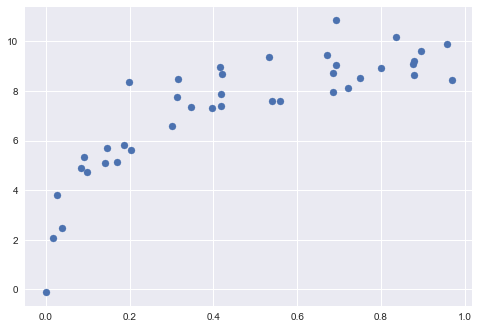

In [5]:
X, y = make_data(40, error=1)
plt.scatter(X, y);

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

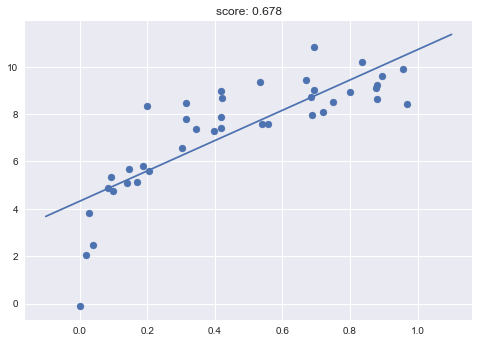

In [7]:
# generate another set of data
X2 = np.linspace(-0.1, 1.1, 500)[:, None] # making sure that X is 2D

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y2 = model.predict(X2)

plt.scatter(X, y)
plt.plot(X2, y2)
plt.title(f"score: {model.score(X, y):.3}");

The score here is the $R^2$ score, or coefficient of determination, which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

Let's make a convenience routine to do this:

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

Now we'll use this to fit a quadratic curve to the data.

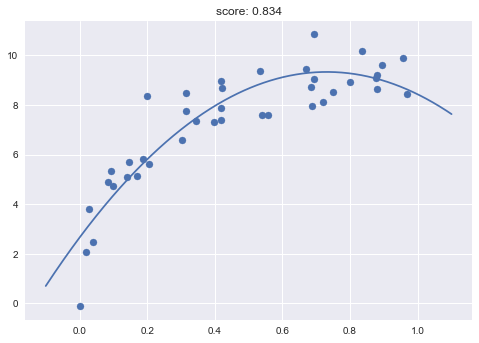

In [9]:
model = PolynomialRegression(2)
model.fit(X, y)
y2 = model.predict(X2)

plt.scatter(X, y)
plt.plot(X2, y2)
plt.title(f"score: {model.score(X, y):.3}");

This improves the score, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

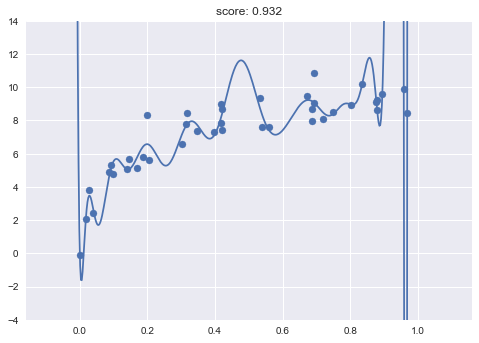

In [10]:
model = PolynomialRegression(30)
model.fit(X, y)
y2 = model.predict(X2)

plt.scatter(X, y)
plt.plot(X2, y2)
plt.title(f"score: {model.score(X, y):.3}")
plt.ylim(-4, 14);

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

Just for fun, let's use Jupyter Widgets' ``interact`` capability to explore this interactively:

In [11]:
from ipywidgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X2 = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y2 = model.predict(X2)

    plt.scatter(X, y)
    plt.plot(X2, y2)
    plt.ylim(-4, 14)
    plt.title(f"score: {model.score(X, y):.3}");
    
interact(plot_fit, degree=(1, 30), Npts=(2, 100));

interactive(children=(IntSlider(value=1, description='degree', max=30, min=1), IntSlider(value=50, description…

### Quick Question

Which polynomial degree gives the most stable estimate when changing the input data, while keeping a high score?

### Detecting Over-fitting with Validation Curves

Clearly, computing the error on the training data is not enough (we saw this previously). As above, we can use **cross-validation** to get a better handle on how the model fit is working.

Let's do this here, again using the ``validation_curve`` utility.

In [12]:
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree',
                                          param_range=degree, cv=5)

Now let's plot the validation curves:

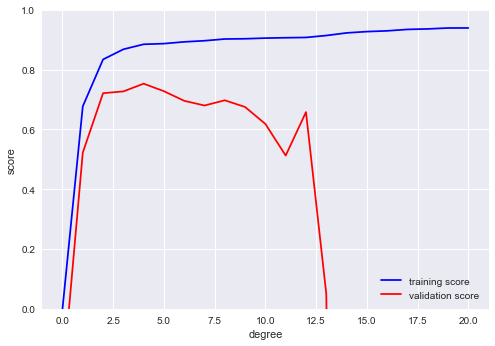

In [13]:
plt.plot(degree, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training score and validation score are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

![Data Layout](images/05.03-validation-curve.png)

(Figure from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

Here's our best-fit model according to the cross-validation:

In [ ]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X2, model.predict(X2));

### Detecting Data Sufficiency with Learning Curves

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

To make things more clear, we'll use a slightly larger dataset:

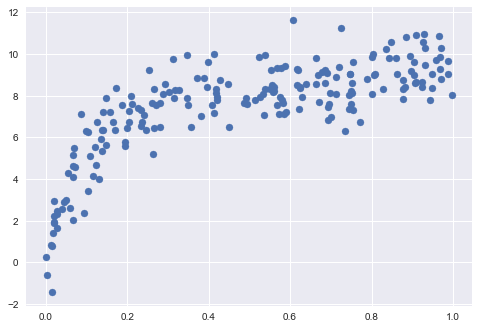

In [14]:
X, y = make_data(200, error=1.0)
plt.scatter(X, y);

The idea is to plot the score for the training and test set as a function of *Number of Training Points*.

In [18]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree):
    train_sizes = np.linspace(0.05, 1, 120)
    N_train, train_score, val_score = learning_curve(
        PolynomialRegression(degree), X, y, train_sizes=train_sizes, cv=10
    )
    plt.plot(N_train, np.mean(train_score, 1), color='blue', label='training score')
    plt.plot(N_train, np.mean(val_score, 1), color='red', label='validation score')
    plt.legend(loc='best')
    plt.ylim(0, 1)
    plt.xlim(N_train[0], N_train[-1])
    plt.xlabel('training size')
    plt.ylabel('score')

Let's see what the learning curves look like for a linear model:

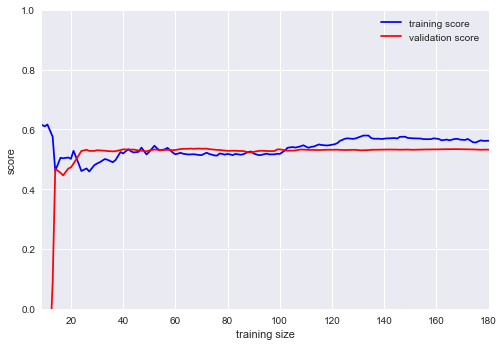

In [16]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test score, which indicates **over-fitting**. Given the same model, for a large number of training points, the training and testing scores converge, which indicates potential **under-fitting**.

As you add more data points, the training score will never decreqse, and the testing score will never increase (why do you think this is?).

It is easy to see that, in this plot, if you'd like to improve the score to the nominal value of 0.8, then adding more samples will *never* get you there. For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

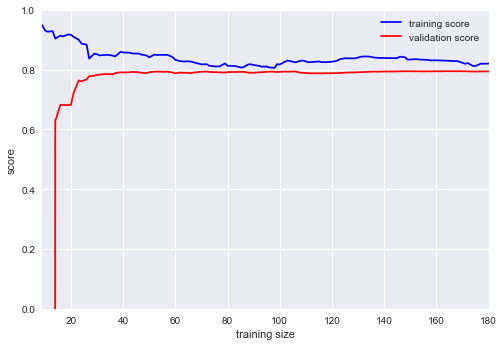

In [17]:
plot_learning_curve(4)

Here we see that by adding more model complexity, we've managed to increase the level of convergence to a score error of 0.8!

What if we get even more complex?

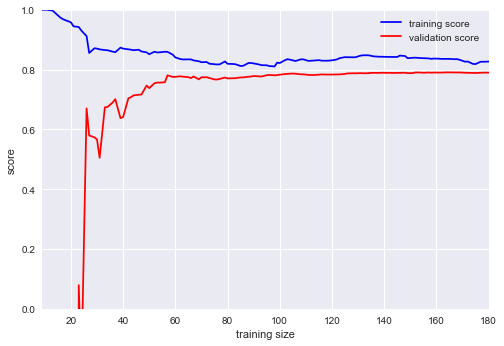

In [19]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

![Data Layout](images/05.03-learning-curve.png)

(Figure from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model. The answer to this question has real consequences, and can be addressed using these metrics.

## Summary

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.